In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.fft

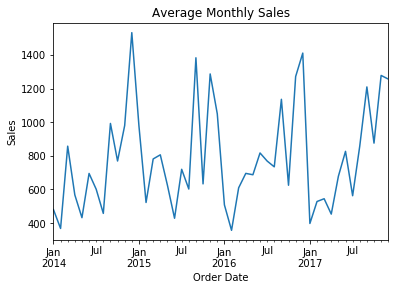

In [2]:
#load the data
df = pd.read_excel("Superstore.xls")
#df.loc accesses a group of rows and columns by labels or a boolean array
furniture = df.loc[df.Category == "Furniture"]

#pull out just order date and sales
furniture = furniture[['Order Date', 'Sales']].sort_values('Order Date')

#multiple orders are placed on the same day, so we will need to sum them up
#grouping by the order date, sum up the sales and reset the index
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

#set the index as the order date
furniture = furniture.set_index('Order Date')

#resample the data into months
y = furniture['Sales'].resample('MS').mean()
y.plot()
plt.ylabel('Sales')
plt.title('Average Monthly Sales')
plt.show()

In [3]:
def fourier_predict(x, k, num_components, d):
    """
    :param x: timeseries data
    :param k: prediction horizon
    :param num_components: number of fourier components to keep
    :param d: sampling rate
    """
    #find freqs for largest PSD components
    
    n = x.size
    #compute fourier transform
    x_fft = scipy.fft.fft(x)
    
    #compute power spectral density
    x_psd = np.abs(x_fft)**2
    
    #compute fourier frequencies
    freqs = scipy.fft.fftfreq(n,d)
    
    #find largest PSD components
    idxs_psd_freqs = list(range(len(freqs)))
    idxs_psd_freqs.sort(key = lambda i: np.log10(x_psd[i]), reverse=True)
    
    #reconstitute the timeseries with the fourier frequencies
    t = np.arange(0, n + k)
    signal = np.zeros(t.size)
    for j in idxs_psd_freqs[:1 + 2*num_components]:
        magnitude = np.abs(x_fft[j])/n
        phase_angle = np.angle(x_fft[j])
        signal += magnitude * np.cos(2 * np.pi * freqs[j] * d * t + phase_angle)
    
    predict = signal[0:n]
    forecast = signal[n:n+k]
    
    return signal, predict, forecast

In [4]:
#split the data into training and testing sets
y_train = y.values[0:36]
y_test = y.values[36:48]

#predict and forecast the timeseries using fourier decomposition
d = 1/12
k = 12
num_harm = 6
signal, predict, forecast = fourier_predict(y_train, k, num_harm, d)

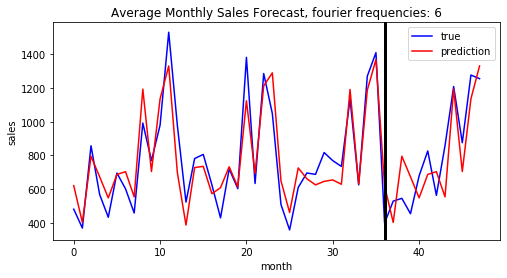

In [5]:
#plot results
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(y.values,'b',label='true')
ax.plot(signal,'r',label='prediction')
ax.axvline(x=36, c='black', lw=3)
ax.set_xlabel('month')
ax.set_ylabel('sales')
ax.set_title('Average Monthly Sales Forecast, fourier frequencies: ' + str(num_harm))
plt.legend()
plt.show()